In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot
import math

In [2]:
input = pd.read_csv("//Users//sweethome//Desktop//UIS//Dataanalytics_capstone//owid_covid_data.csv")

In [62]:
print(input.head())
print(input.shape)

         date iso_code continent     location  total_cases  new_cases  \
0  2020-02-24      AFG      Asia  Afghanistan          5.0        5.0   
1  2020-02-25      AFG      Asia  Afghanistan          5.0        0.0   
2  2020-02-26      AFG      Asia  Afghanistan          5.0        0.0   
3  2020-02-27      AFG      Asia  Afghanistan          5.0        0.0   
4  2020-02-28      AFG      Asia  Afghanistan          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                      

In [63]:
print(206186/213332)
input.isna().sum()

0.9665029156432228


date                                            0
iso_code                                        0
continent                                   12296
location                                        0
total_cases                                  8907
                                            ...  
excess_mortality                           206143
excess_mortality_cumulative_per_million    206186
day                                             0
month                                           0
year                                            0
Length: 70, dtype: int64

In [5]:
#removing columns with too many missing values
data= input.drop(["excess_mortality","excess_mortality_cumulative_per_million","weekly_hosp_admissions","weekly_hosp_admissions_per_million",
                   "weekly_icu_admissions_per_million","weekly_icu_admissions","total_boosters","total_boosters_per_hundred",
                   "excess_mortality_cumulative_absolute","excess_mortality_cumulative","total_boosters","total_boosters_per_hundred",
                   "icu_patients","icu_patients_per_million","hosp_patients","hosp_patients_per_million"],axis=1)

In [6]:
data.shape

(213332, 56)

In [7]:
data.head()

,date,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,day,month,year
0,2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,...,9.59,NaN,NaN,37.746,0.5,64.83,0.511,24,2,2020
1,2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,9.59,NaN,NaN,37.746,0.5,64.83,0.511,25,2,2020
2,2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,9.59,NaN,NaN,37.746,0.5,64.83,0.511,26,2,2020
3,2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,9.59,NaN,NaN,37.746,0.5,64.83,0.511,27,2,2020
4,2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,9.59,NaN,NaN,37.746,0.5,64.83,0.511,28,2,2020


In [8]:
data["continent"].unique()

array(['Asia', nan, 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [9]:
#removing the rows where continent is nan
data.dropna(subset = ['continent'], inplace=True)

In [10]:
data.shape

(201036, 56)

In [11]:
#removing the rows for locations where data is too less and not reliable
data=data[~data.location.isin(["Guam","Guernsey","Jersey","Nauru","Niue","Northern Cyprus","Northern Mariana Islands", 
                                "Pitcairn","PuertoRico","SintMaarten(Dutchpart)","Tokelau","Turkmenistan","Tuvalu", 
                                "United States Virgin Islands","Western Sahara","North Korea","Saint Helena"])]

In [12]:
data.shape

(193424, 56)

In [13]:
print(data.dtypes)

date                                           object
iso_code                                       object
continent                                      object
location                                       object
total_cases                                   float64
new_cases                                     float64
new_cases_smoothed                            float64
total_deaths                                  float64
new_deaths                                    float64
new_deaths_smoothed                           float64
total_cases_per_million                       float64
new_cases_per_million                         float64
new_cases_smoothed_per_million                float64
total_deaths_per_million                      float64
new_deaths_per_million                        float64
new_deaths_smoothed_per_million               float64
reproduction_rate                             float64
total_tests                                   float64
new_tests                   

In [14]:
#converting date column of object type to date type
data["date"] = pd.to_datetime(data["date"])

In [15]:
#preparing data for machine learning
data['day of week'] = data['date'].dt.dayofweek

In [16]:
data.rename(columns={'day': 'day of month', 'location': 'country'}, inplace=True)

In [17]:
data.head()

,date,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,day of month,month,year,day of week
0,2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,24,2,2020,0
1,2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,25,2,2020,1
2,2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,26,2,2020,2
3,2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,27,2,2020,3
4,2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,28,2,2020,4


In [18]:
data_usa=data[data.country.isin(["United States"])]

In [19]:
data_usa_train=data_usa[(data_usa['date']>='2020-02-01') & 
                                    (data_usa['date']<'2022-07-24')]
data_usa_test=data_usa[(data_usa['date']>='2022-07-25') & 
                                    (data_usa['date']<'2022-08-08')]

In [20]:
len(data_usa_train)


904

In [21]:
len(data_usa_test)
#covid_data_usa_train.head(90)

14

In [22]:
result = adfuller(data_usa_train.total_cases.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.574698
p-value: 0.986975


<AxesSubplot:>

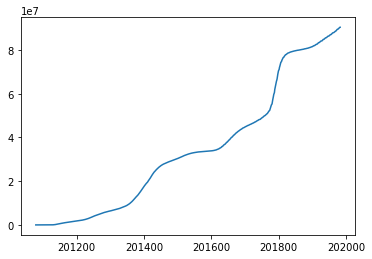

In [23]:
data_usa_train['total_cases'].plot()

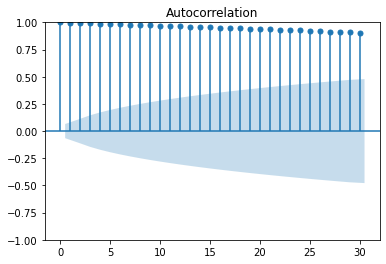

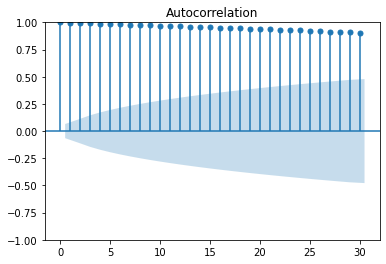

In [24]:
plot_acf(data_usa_train['total_cases'].dropna(),lags=30)


/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


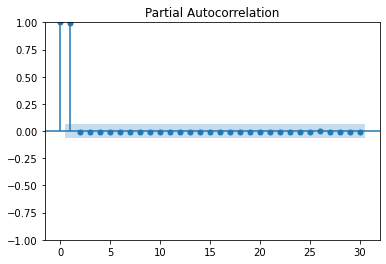

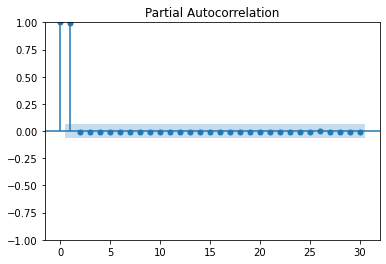

In [25]:
plot_pacf(data_usa_train['total_cases'].dropna(),lags=30)

In [37]:
diff1 = data_usa_train['total_cases'].diff()

In [39]:
result = adfuller(diff1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.381461
p-value: 0.000320


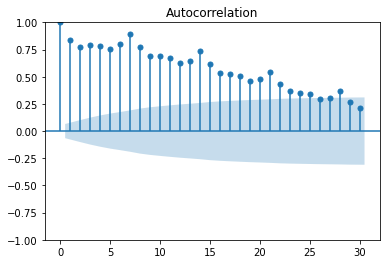

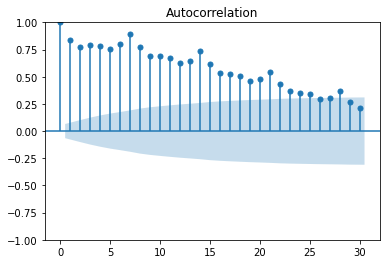

In [41]:
plot_acf(diff1.dropna(),lags=30)


/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


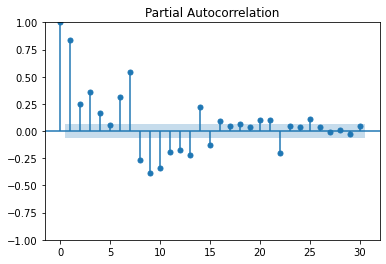

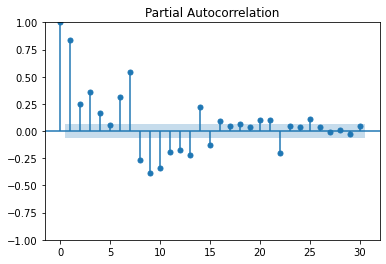

In [43]:
plot_pacf(diff1.dropna(),lags=30)

<AxesSubplot:>

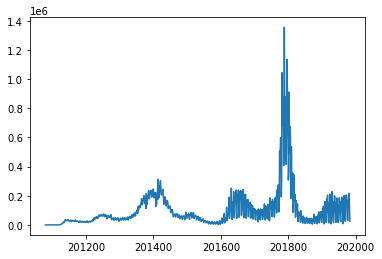

In [44]:
diff1.plot()

In [45]:

diff2 = diff1.diff()

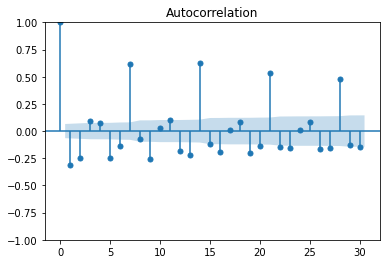

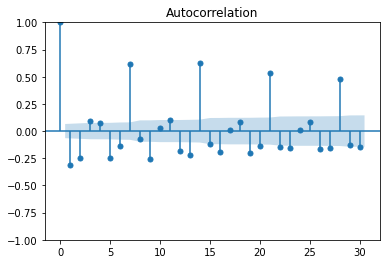

In [46]:
plot_acf(diff2.dropna(),lags=30)

/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


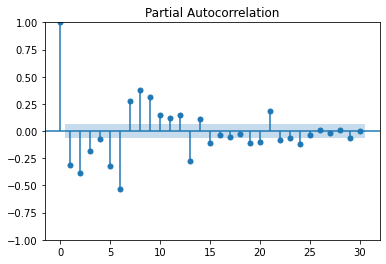

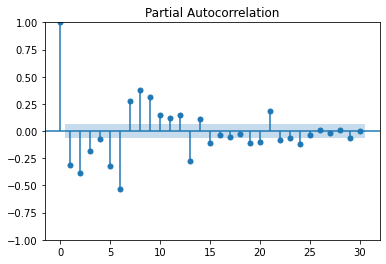

In [47]:
plot_pacf(diff2.dropna(),lags=30)

<AxesSubplot:>

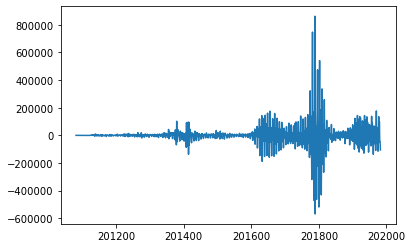

In [48]:
diff2.plot()

In [73]:
def arima_forecast(df,order):
    model = ARIMA(df['total_cases'], order=order)
    return model.fit()

In [75]:
model_1 = arima_forecast(data_usa_train,(7,2,1))
print(model_1.summary())
model_2 = arima_forecast(data_usa_train,(1,2,1))
print(model_2.summary())
model_3 = arima_forecast(data_usa_train,(1,2,7))
print(model_3.summary())

/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  904
Model:                 ARIMA(7, 2, 1)   Log Likelihood              -11004.170
Date:                Sat, 03 Dec 2022   AIC                          22026.341
Time:                        18:03:34   BIC                          22069.583
Sample:                             0   HQIC                         22042.858
                                - 904                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0477      0.015      3.267      0.001       0.019       0.076
ar.L2         -0.0711      0.017     -4.242      0.000      -0.104      -0.038
ar.L3          0.0139      0.013      1.075      0.2

/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An u

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  904
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -11176.588
Date:                Sat, 03 Dec 2022   AIC                          22371.175
Time:                        18:03:34   BIC                          22414.417
Sample:                             0   HQIC                         22387.692
                                - 904                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4530      0.056     -8.068      0.000      -0.563      -0.343
ma.L1         -0.2139      0.048     -4.467      0.000      -0.308      -0.120
ma.L2         -0.3917      0.042     -9.255      0.0

In [77]:
#data_usa_test=data_usa_test.drop(columns=["index"])
#data_usa_test = data_usa_test.reset_index()

test_values = pd.DataFrame(model_1.forecast(steps=len(data_usa_test)))
test_values = test_values.reset_index()
test_values
data_usa_test["ARIMA"] = test_values.iloc[:, 1]
#covid_data_usa_test["ARIMA"] = test_values['predicted_mean']

data_usa_test
#covid_data_usa_test
#covid_data_usa_test.drop(columns=["ARIMA","Prediction","a","pred_values"])

/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,level_0,index,date,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,day of month,month,year,day of week,ARIMA
0,0,201984,2022-07-25,USA,North America,United States,90626223.0,189868.0,125747.286,1027837.0,...,24.6,NaN,2.77,78.86,0.926,25,7,2022,0,9.046537e+07
1,1,201985,2022-07-26,USA,North America,United States,90758320.0,132097.0,127877.286,1028387.0,...,24.6,NaN,2.77,78.86,0.926,26,7,2022,1,9.060974e+07
2,2,201986,2022-07-27,USA,North America,United States,90998232.0,239912.0,131222.143,1029340.0,...,24.6,NaN,2.77,78.86,0.926,27,7,2022,2,9.073185e+07
3,3,201987,2022-07-28,USA,North America,United States,91175175.0,176943.0,131448.857,1029740.0,...,24.6,NaN,2.77,78.86,0.926,28,7,2022,3,9.091287e+07
4,4,201988,2022-07-29,USA,North America,United States,91334992.0,159817.0,135432.429,1030366.0,...,24.6,NaN,2.77,78.86,0.926,29,7,2022,4,9.107298e+07
5,5,201989,2022-07-30,USA,North America,United States,91350935.0,15943.0,133962.857,1030397.0,...,24.6,NaN,2.77,78.86,0.926,30,7,2022,5,9.118922e+07
6,6,201990,2022-07-31,USA,North America,United States,91363870.0,12935.0,132502.143,1030409.0,...,24.6,NaN,2.77,78.86,0.926,31,7,2022,6,9.123222e+07
7,7,201991,2022-08-01,USA,North America,United States,91533934.0,170064.0,129673.000,1030983.0,...,24.6,NaN,2.77,78.86,0.926,1,8,2022,0,9.129972e+07
8,8,201992,2022-08-02,USA,North America,United States,91624786.0,90852.0,123780.857,1031493.0,...,24.6,NaN,2.77,78.86,0.926,2,8,2022,1,9.143123e+07
9,9,201993,2022-08-03,USA,North America,United States,91825411.0,200625.0,118168.429,1032588.0,...,24.6,NaN,2.77,78.86,0.926,3,8,2022,2,9.155328e+07


In [78]:
#Evaluation Metrics

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def MAE(y_actual, y_predictions):
    y_actual, y_predictions = np.array(y_actual), np.array(y_predictions)
    return np.mean(np.abs(y_actual - y_predictions))

def RMSE(y_actual, y_predictions):
    return math.sqrt(np.square(np.subtract(y_actual,y_predictions)).mean())

def NRMSE(y_actual: np.ndarray, y_predictions: np.ndarray):
    return RMSE(y_actual, y_predictions) / (y_actual.max() - y_actual.min())

In [79]:
MAPE(data_usa_test.total_cases,data_usa_test.ARIMA)

0.23028379863383

In [80]:
MAE(data_usa_test.total_cases,data_usa_test.ARIMA)

210758.97360877905

In [81]:
RMSE(data_usa_test.total_cases,data_usa_test.ARIMA)

218716.52662951476

In [82]:
NRMSE(data_usa_test.total_cases,data_usa_test.ARIMA)

0.14388080874344691

In [83]:
def arimamodel(timeseriesdf):
    autoarima_model = auto_arima(timeseriesdf.total_cases, 
                                start_p=0, start_q=0, max_p=7, max_q=7,
                                seasonal=False,
                                d=None, trace=True, enforce_stationarity=False, enforce_invertibility = False,
                                error_action='ignore', suppress_warnings=True, maxiter = 50, stepwise=True)
    return autoarima_model

In [84]:
arima_model = arimamodel(data_usa_train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22918.110, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=22827.365, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=22646.521, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=22916.112, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=22636.560, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=22599.106, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=22681.775, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=22601.069, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=22435.816, Time=0.65 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=22609.028, Time=0.12 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=22668.952, Time=0.55 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=22457.633, Time=0.47 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=22496.255, Time=0.31 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=22458.145, Time=0.78 sec
 ARIMA(2,2,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  904
Model:               SARIMAX(2, 2, 2)   Log Likelihood              -11211.765
Date:                Sat, 03 Dec 2022   AIC                          22433.531
Time:                        18:13:14   BIC                          22457.554
Sample:                             0   HQIC                         22442.707
                                - 904                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9063      0.015     59.955      0.000       0.877       0.936
ar.L2         -0.5278      0.012    -45.528      0.000      -0.551      -0.505
ma.L1         -1.6388      0.014   -117.038      0.000      -1.666      -1.611
ma.L2          0.8870      0.013     69.953      0.000       0.862       0.912
sigma2      4.348e+09   1.09e-12      4e+21      0.000    4.35e+09    4.35e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.80   Jarque-Bera (JB):             18346.22
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):             117.19   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.98e+36. Standard errors may be unstable.
"""

In [97]:
data_usa_test=data_usa_test.drop(columns=["index"])
data_usa_test = data_usa_test.reset_index()

test_values = pd.DataFrame(arima_model.predict(len(data_usa_test)))
test_values = test_values.reset_index()
test_values
data_usa_test["ARIMA"] = test_values.iloc[:, 1]


data_usa_test['ARIMA']=pd.to_numeric(data_usa_test['ARIMA'], downcast="float")
data_usa_test


/Users/sweethome/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,index,level_0,date,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,day of month,month,year,day of week,ARIMA
0,0,0,2022-07-25,USA,North America,United States,90626223.0,189868.0,125747.286,1027837.0,...,24.6,NaN,2.77,78.86,0.926,25,7,2022,0,90488288.0
1,1,1,2022-07-26,USA,North America,United States,90758320.0,132097.0,127877.286,1028387.0,...,24.6,NaN,2.77,78.86,0.926,26,7,2022,1,90624848.0
2,2,2,2022-07-27,USA,North America,United States,90998232.0,239912.0,131222.143,1029340.0,...,24.6,NaN,2.77,78.86,0.926,27,7,2022,2,90791328.0
3,3,3,2022-07-28,USA,North America,United States,91175175.0,176943.0,131448.857,1029740.0,...,24.6,NaN,2.77,78.86,0.926,28,7,2022,3,90952480.0
4,4,4,2022-07-29,USA,North America,United States,91334992.0,159817.0,135432.429,1030366.0,...,24.6,NaN,2.77,78.86,0.926,29,7,2022,4,91093008.0
5,5,5,2022-07-30,USA,North America,United States,91350935.0,15943.0,133962.857,1030397.0,...,24.6,NaN,2.77,78.86,0.926,30,7,2022,5,91217664.0
6,6,6,2022-07-31,USA,North America,United States,91363870.0,12935.0,132502.143,1030409.0,...,24.6,NaN,2.77,78.86,0.926,31,7,2022,6,91338808.0
7,7,7,2022-08-01,USA,North America,United States,91533934.0,170064.0,129673.000,1030983.0,...,24.6,NaN,2.77,78.86,0.926,1,8,2022,0,91465160.0
8,8,8,2022-08-02,USA,North America,United States,91624786.0,90852.0,123780.857,1031493.0,...,24.6,NaN,2.77,78.86,0.926,2,8,2022,1,91598072.0
9,9,9,2022-08-03,USA,North America,United States,91825411.0,200625.0,118168.429,1032588.0,...,24.6,NaN,2.77,78.86,0.926,3,8,2022,2,91734200.0


In [98]:
print("MAPE : ",MAPE(data_usa_test.total_cases,data_usa_test.ARIMA))
print("MAE : ",MAE(data_usa_test.total_cases,data_usa_test.ARIMA))
print("RMSE : ",RMSE(data_usa_test.total_cases,data_usa_test.ARIMA))
print("NRMSE : ",NRMSE(data_usa_test.total_cases,data_usa_test.ARIMA))

MAPE :  0.1303209090783942
MAE :  119083.42857142857
RMSE :  138371.82254914267
NRMSE :  0.09102672780369922
